##### <p style="text-align: center;">MIS 285N - Big Data and Distributed Programming</p>
## <p style="text-align: center;">Project 2 - Machine Learning using Scikit and AWS</p>
## <p style="text-align: center;">Total points: 100</p>
## <p style="text-align: center;">Due: Friday, October 8 submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

This project is about giving exposure about Machine learning, its usage, Cloud services and why they are helpful in analyzing Big Data.

In this Project, we are trying to analyze the crime data. This data is taken from <a href=https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data> here </a>. You have to download data from here, it should be around 1.6 GB in size. You will predict the type of crime that can happen given the features.

You have to complete all the four tasks and report your observations for each if any.

Note: Please post clarification questions on Piazza. 

# Task 1 - Read the data and filter the data you need

This is open ended, you can use any features you want and drop any one of them. The 'Primary Type' is our target variable which we will be predicting for.

Hint: Split the data into training and testing in the ratio of 80:20.

This task is split into multiple parts:

In [ ]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
from google.colab import drive
import time

drive.mount('/content/drive')

start = time.time()
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big Data/Project 2/Crimes_-_2001_to_Present.csv")

Mounted at /content/drive


1.   Print the Histogram of variable 'Primary Type'. The x-axis should be each primary type, and the y-axis will be the count of each Primary type.

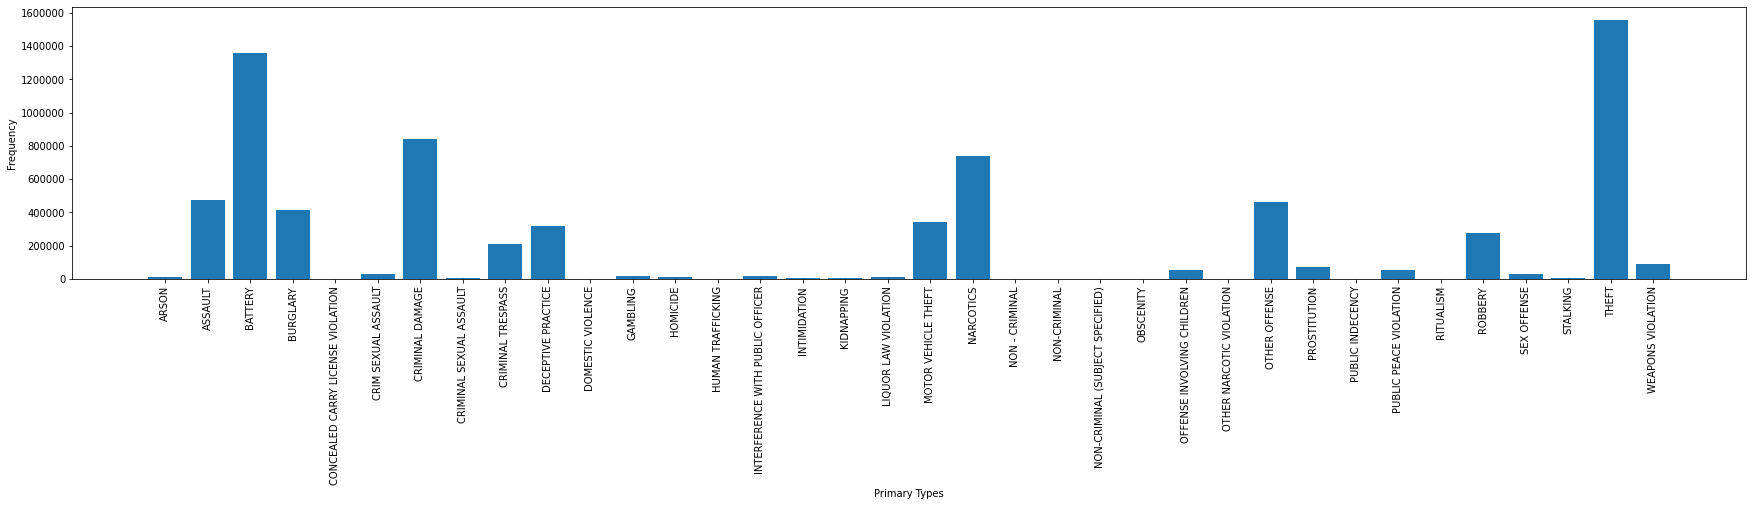

In [ ]:
df_histogram = df.groupby(['Primary Type'])['Primary Type'].agg(['count'])

fig, ax = plt.subplots(figsize=(30,5))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)    
ax.set_xticklabels(df_histogram.index, rotation=90)
ax.set_xlabel('Primary Types')
ax.set_ylabel('Frequency')
ax.bar(df_histogram.index, df_histogram['count'].values)
plt.show()

2. Sort the histogram in decreasing order. This will help you to understand which Primary Type of crime occured more than the rest. 

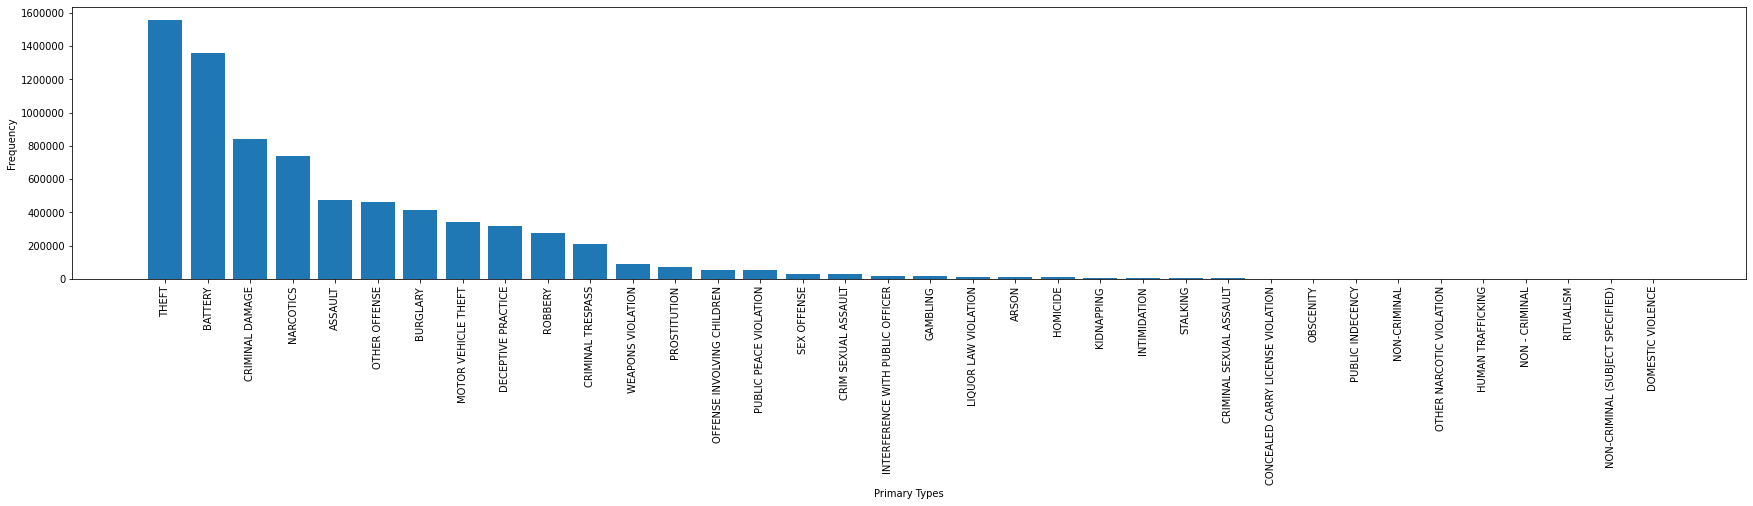

In [ ]:
df_histogram_sorted = df.groupby(['Primary Type'])['Primary Type'].agg(['count']).sort_values(by='count', ascending=False)

fig, ax = plt.subplots(figsize=(30,5))
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)    
ax.set_xticklabels(df_histogram_sorted.index, rotation=90)
ax.set_xlabel('Primary Types')
ax.set_ylabel('Frequency')
ax.bar(df_histogram_sorted.index, df_histogram_sorted['count'].values)
plt.show()

3. Now, 'K' is the total number of classes in Primary Type. Experiment with K=2,3,4,5 as the most popular Primary Type data to be used and predicted. 

In [ ]:
# create function to return top "k" classes and their count
def k_classes (df, K):
  return df.groupby(['Primary Type'])['Primary Type'].agg(['count']).sort_values(by='count', ascending=False).head(K)

# demonstrating for k = 5. Please see section Task 1 (Continued) for k = 2,3 and 4
K = 5
top_k_classes = k_classes(df, K)
print(f'Top {K} classes \n {top_k_classes}')

#creating dataframe with only top k classes
df_copy = df.loc[df['Primary Type'].isin(top_k_classes.index)].copy()

Top 5 classes 
                    count
Primary Type            
THEFT            1557434
BATTERY          1357770
CRIMINAL DAMAGE   844023
NARCOTICS         739107
ASSAULT           474089


4.  For a given K, filter the dataset to extract the most popular K Primary Types and report what percentage of the total dataset this amounts to. Lets call this percentage, F. Now, find what fraction of this filtered data can be supported in your analysis on your local machine. Lets call this P. For example, of the approximately 7 million entries, say for K=3, we find that the top three types of crime add up to around 3.5 million, which makes F be 50%. Now see if your machine can handle all 3.5 million entries in you ML analysis. Say you find out that you can only handle 60% of this, which means your working dataset will be 2.1 million entries.  

In [ ]:
# calculating percentage of total dataset by taking sum of frequencies of top K primary types and dividing by the length of the complete dataset
F = top_k_classes.values.sum()/ len(df)

print(f'Percentage of {K} classes of the total dataset: \n {F*100}')

Percentage of 5 classes of the total dataset: 
 67.16901810275283


# Task 2 - Convert the features in a form that can be given as input to scikit library/functions

Here you have to search a little bit. The data that we are using has data other than numerical values. The model takes values as numerical or categorical data. You need to convert the input data to either one of these forms. 

1.   Case Number, FBI Code, Updated On and IUCR are random values that have no relation to our dependant variable
2.   X Coordinate, Y Coordinate and Location are all repeated variables so we are dropping those as well
3.   We are removing Date column because we are not including timeseries in our analysis

In [ ]:
# Dropping all rows that contain Null values because they were mostly empty locations, which cannot be replaced with mean, mode or median of the column
df_copy.dropna(axis=0,inplace=True)

# Dropping columns that are unrelated to Primary Type
df_copy.drop(['ID', 'Case Number', 'FBI Code', 'Updated On', 'IUCR', 'X Coordinate', 'Y Coordinate', 'Location', 'Date'], axis=1, inplace=True)
df_copy.reset_index(drop=True, inplace=True)

# verify nan values - no NaN values
print(str('\n') + str(df_copy.isnull().sum()))


Block                   0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
Year                    0
Latitude                0
Longitude               0
dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# identify categorical columns
# Remove 'Primary Type' as it our predictor.
cat_cols = df_copy.select_dtypes("object").columns
cat_cols = [cat for cat in cat_cols if cat not in ('Primary Type')]
num_cols = df_copy.select_dtypes("number").columns

# Adding arrest and domestic to categorical list so the values can be converted to 0 and 1's
cat_cols.append('Arrest')
cat_cols.append('Domestic')

# with this we have a better understanding of columns
print('Categorical Columns: ' + str(cat_cols))
print('Numerical Columns: ' + str(num_cols.values))

X = df_copy.drop(['Primary Type'], axis=1)
y = df_copy['Primary Type']

# Converting categorical columns into labels
for c in cat_cols:
    lbl = LabelEncoder() 
    lbl.fit(X[c].values)
    X[c] = lbl.transform(X[c].values)

# Converting truth values into labels
lbl = LabelEncoder() 
lbl.fit(y.values)
y = lbl.transform(y.values)

Categorical Columns: ['Block', 'Description', 'Location Description', 'Arrest', 'Domestic']
Numerical Columns: ['Beat' 'District' 'Ward' 'Community Area' 'Year' 'Latitude' 'Longitude']


In [ ]:
X.head(5)

,Block,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,20747,75,103,0,1,924,9.0,12.0,61.0,2015,41.815117,-87.670000
1,4677,121,48,0,0,1511,15.0,29.0,25.0,2015,41.895080,-87.765400
2,17827,131,120,1,0,1412,14.0,35.0,21.0,2015,41.937406,-87.716650
3,259,160,17,0,1,1522,15.0,28.0,25.0,2015,41.881903,-87.755121
4,13455,156,71,1,0,1034,10.0,25.0,31.0,2015,41.851989,-87.689219


In [ ]:
# understand the Primary types (target)
df_copy["Primary Type"].value_counts()

THEFT              1417347
BATTERY            1235123
CRIMINAL DAMAGE     769160
NARCOTICS           662501
ASSAULT             432802
Name: Primary Type, dtype: int64

# Task 1 (Continued)

5.  For each K=2,3,4,5 (and associated percentage 'P'), you should train a model and report the accuracy. (Refer to other tasks)

In our case, the associated percentage 'P' was 100% for every K because there were no runtime errors and the local computer was able to handle the complete dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeRegressor

df_new = X.copy()
df_new['Primary Type'] = y

# Getting labels sorted by frequency to select data from the dataframe before running each model
labels = df_new['Primary Type'].value_counts()
print(labels)

4    1417347
1    1235123
2     769160
3     662501
0     432802
Name: Primary Type, dtype: int64


In [ ]:
k_list = []
F = []
Accuracy = []
F1_Score = []
Precision = []
Recall = []

for label in labels.index:
  k_list.append(label)
  
  X_task3 = df_new.loc[df_new['Primary Type'].isin(k_list)]
  y_task3 = X_task3['Primary Type']
  X_task3 = X_task3.drop(['Primary Type'], axis=1)

  f_sum = 0
  for i in k_list:
    f_sum += labels[i]

  F.append((f_sum/len(df))*100)

  # Division into train and test (80:20)
  X_train, X_test, y_train, y_test =  train_test_split(X_task3, y_task3, test_size=0.2, random_state=0)

  # train the model using DecisionTrees
  tree_reg = DecisionTreeRegressor()
  tree_reg.fit(X_train,y_train)
  y_pred = [int(i) for i in tree_reg.predict(X_test)]

  Accuracy.append(accuracy_score(y_test, y_pred))
  F1_Score.append(f1_score(y_test, y_pred, average='macro'))
  Precision.append(precision_score(y_test, y_pred, average='macro'))
  Recall.append(recall_score(y_test, y_pred, average='macro'))

As we increase the number of K from 1 to 5, we can see that the model's accuracy deteriorates as there are more labels/options to choose from and hence it is easier for the model to make a mistake.

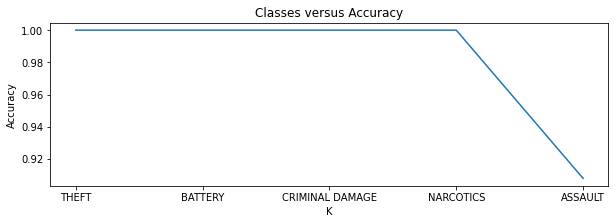

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(top_k_classes.index, Accuracy)
plt.ticklabel_format(axis="y",useOffset=False,style='plain')
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.title('Classes versus Accuracy')
plt.show()

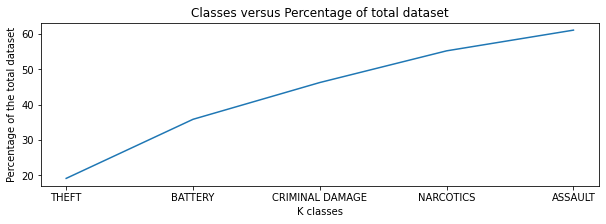

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(top_k_classes.index, F)
plt.ylabel('Percentage of the total dataset')
plt.xlabel('K classes')
plt.title('Classes versus Percentage of total dataset')
plt.show()

# Task 3 - Build the model

Once the features are converted to the form accepted by scikit library, you have to build a machine learning model. Given the features predict the type of crime. 
Report the accuracy, F1, Precision and Recall of the model.

In [ ]:
# Selecting data with the top 5 Primary Type Labels
X = df_new.loc[df_new['Primary Type'].isin(labels.index)]
y = X['Primary Type']
X = X.drop(['Primary Type'], axis=1)

# Division into train and test (80:20)
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)
y_pred = [int(i) for i in tree_reg.predict(X_test)]

end = time.time()
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred, average='macro')))
print('Precision Score: ' + str(precision_score(y_test, y_pred, average='macro')))
print('Recall Score: ' + str(recall_score(y_test, y_pred, average='macro')))

Accuracy: 0.9079641393998364
F1 Score: 0.8742953119108854
Precision Score: 0.8721689422594899
Recall Score: 0.8771792590826457


# Task 4 - Run the model on your laptop and AWS cloud and observe the time taken for reading the data, training and testing, report the same.  

Report your observations. Due to more RAM needed for the same, it might be the case that it doesn't run on your laptop, so in that case report your laptop configuration and state it didnt run.

In [ ]:
#download dataframe to run model in aws
#X.to_csv('for_aws.csv',encoding='utf-8')

In [ ]:
#y.to_csv('labels.csv',encoding='utf-8')

In [ ]:
print(f'Elapsed time taken for reading the data, training and testing model on laptop is {end-start} seconds.')

Elapsed time taken for reading the data, training and testing model on laptop is 86.07364654541016 seconds.


Uploading dataset on AWS cloud free tier terminated with memory error. Follow-up submission will be done after Dr.Y sets up the educate account.

We ran our model on the following two machines:
1.   Google Colab: 86.07364654541016 seconds
2.   Local Laptop: 73.390221118927 seconds



# Task 5 - Run K-fold cross validation and report the accuracy for a cv = 5. 
Report the total amount of time taken to run it on your laptop and AWS

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeRegressor(), X_train, y_train, cv=5)
print('Average Cross Validation Accuracy: ' + str(np.average(scores)))

Average Cross Validation Accuracy: 0.9559797900544738
